# CNNスクラッチ1

## 1次元の畳み込みニューラルネットワークスクラッチ

**畳み込みニューラルネットワーク（CNN）**のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


このSprintでは1次元の**畳み込み層**を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。


クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。

### 1次元畳み込み層とは

CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。


畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。

### データセットの用意

検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

In [1]:
# ミニバッチ処理のクラス
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=None):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1] 
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

**全結合層**

In [2]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        self.A = np.dot(self.X,self.W) + self.B
        
        return self.activation.forward(self.A)
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dA = self.activation.backward(dZ)
        self.dB = np.mean(dA,axis=0)
        self.dW = np.dot(self.X.T,dA)/len(self.X)
        dZ = np.dot(dA,self.W.T)
        
        # 更新
        self = self.optimizer.update(self)
        
        return dZ

In [3]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 重み
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : バイアス
        """
        return np.zeros(n_nodes2)

In [4]:
class HeInitializer():
    """
    Heによる重みの初期化
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 重み
        """
        return np.random.randn(n_nodes1, n_nodes2)*np.sqrt(2/n_nodes1)
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : バイアス
        """
        return np.zeros(n_nodes2)

In [5]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr*layer.dW
        layer.B -= self.lr*layer.dB
        
        return layer


In [6]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.hW = 0
        self.hB = 0
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        self.hW += layer.dW*layer.dW
        self.hB = layer.dB*layer.dB
    
        layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) +1e-7)
        layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) +1e-7)
        
        return layer

**活性化関数**

In [7]:
class ReLU():
    """
    活性化関数 : ReLU関数
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        self.A = A
        return np.maximum(self.A,0)
    
    def backward(self,dZ):
        
        return np.where(self.A>0,dZ,0)

In [8]:
class Softmax():
    """
    活性化関数 : ソフトマックス関数
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        
        return np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)),axis=1,keepdims=True)
    
    def backward(self,dZ):
        return dZ

### 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。


ここでは**パディング**は考えず、**ストライド**も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

$a_i$ : 出力される配列のi番目の値


$F$ : フィルタのサイズ


$x_{(i+s)}$ : 入力の配列の(i+s)番目の値


$w_s$ : 重みの配列のs番目の値


$b$ : バイアス項


全てスカラーです。


次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。

$$
w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s} \\
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}
$$

$\alpha$ : 学習率


$\frac{\partial L}{\partial w_s}$ : $w_s$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial b}$ : $b$ に関する損失 $L$ の勾配


勾配 $\frac{\partial L}{\partial w_s}$ や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。

$$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\\
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値


$N_{out}$ : 出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s
$$

$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列のj番目の値


ただし、 $j-s<0$ または $j-s>N_{out}-1$ のとき $\frac{\partial L}{\partial a_{(j-s)}} =0$ です。


全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。


In [9]:
# インポート
import numpy as np
import matplotlib.pyplot as plt
# 評価指標
from sklearn.metrics import accuracy_score

**畳み込み層**

In [10]:
# 1次元畳み込み層クラス
class SimpleConv1d():
    """
    1次元の畳み込み層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, out_channel, in_channel, filter_size, 
                 padding_size=0,stride_size=1,
                 initializer=None,optimizer=None,activation=None):
        
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(out_channel,in_channel,filter_size)
        self.B = self.initializer.B(out_channel)
        
    def output_shape(self,n_feature,filter_size,padding=0,stride=1):
        
        return int((n_feature +2*padding -filter_size)/stride +1)
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        # サイズ
        N,INC,Feature = X.shape
        OCH,INC,FS = self.W.shape
        OUT = self.output_shape(Feature,FS,0,1)
        
        self.size = N,INC,OCH,FS,OUT
        
        A = np.zeros([N,OCH,OUT])

        for n in range(N):
            for och in range(OCH):
                for ich in range(INC):
                    for m in range(OUT):
                        A[n,och,m] += np.sum(X[n,ich,m:m+FS]*self.W[och,ich,:])
                                   
        A += self.B[:,None]
        
        return self.activation.forward(A)
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dA = self.activation.backward(dZ)
        
        # バイアス
        self.dB = np.mean(np.sum(dA,axis=2),axis=0)
        
        # 重み、流す勾配
        self.dW = np.zeros(self.W.shape)
        dZ = np.zeros(self.X.shape)
        
        N,INC,OCH,FS,OUT = self.size 

        for n in range(N):
            for och in range(OCH):
                for ich in range(INC):
                    for fs in range(FS):
                        for m in range(OUT):
                            self.dW[och,ich,fs] += self.X[n,ich,fs+m]*dA[n,och,m]
                            dZ[n,ich,fs+m] += self.W[och,ich,fs]*dA[n,och,m]
        
        # 更新
        self = self.optimizer.update(self)
        
        return dZ

In [11]:
class SimpleInitializerConv1d:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, out_channel, in_channel, filter_size):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 重み
        """
        return self.sigma * np.random.randn(out_channel, in_channel, filter_size)
    
    def B(self, out_channel):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : バイアス
        """
        return np.zeros(out_channel)

In [12]:
# スクラッチ　CNN
class Scratch1dCNNClassifier():
    """
    N層の畳み込みニューラルネットワーク分類器
    
    Parameters
    ----------
    self.n_epoch : エポック数
    self.n_batch : バッチ数
    self.verbose : 学習過程を可視化
    Attributes
    ----------
    """
    def __init__(self, NN, CNN, n_epoch=5, n_batch=1, verbose = False):
        #　パラメータ
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)
        self.log_acc = np.zeros(self.n_epoch)
        self.NN = NN
        self.CNN = CNN
        
    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
    
    def accuracy(self,Z,Y):
        return accuracy_score(Y,Z)
                
    def fit(self, X, y, X_val=False, y_val=False):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        for epoch in range(self.n_epoch):
            # ミニバッチ処理
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            
            self.loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # 順伝播
                forward_data = mini_X_train.reshape(self.n_batch,1,-1)
                
                # Conv
                for layer in range(len(self.CNN)):
                    forward_data = self.CNN[layer].forward(forward_data)
                
                record_shape = forward_data.shape
                forward_data = forward_data.reshape(self.n_batch,-1)
                
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)
                    
                # 予測値
                Z = forward_data
                
                # 逆伝播
                backward_data = (Z - mini_y_train)/self.n_batch
                for layer in range(len(self.NN)-1,-1,-1):
                    backward_data = self.NN[layer].backward(backward_data)
                
                backward_data = backward_data.reshape(record_shape)
                
                for layer in range(len(self.CNN)-1,-1,-1):
                    backward_data = self.CNN[layer].backward(backward_data)
                
                # 損失関数
                self.loss += self.loss_function(Z,mini_y_train)
                
            self.log_loss[epoch] = self.loss/len(get_mini_batch)
            self.log_acc[epoch] = self.accuracy(self.predict(X),np.argmax(y,axis=1))
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        pred_data = X[:,np.newaxis,:]
        
        # Conv
        for layer in range(len(self.CNN)):
            pred_data = self.CNN[layer].forward(pred_data)
                
        pred_data = pred_data.reshape(len(X),-1)
                
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)
            
        return np.argmax(pred_data,axis=1)

### 【問題2】1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。

$$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1\\
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ

In [13]:
def output_shape(X_features, filter_size, padding_size=0, stride_size=1):
    return int((X_features +2*padding_size -filter_size)/stride_size +1)

In [14]:
output_shape(4,3,0,1)

2

### 【問題3】小さな配列での1次元畳み込み層の実験

次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力x、重みw、バイアスbを次のようにします。

In [15]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

# 誤差
delta_a = np.array([10, 20])

In [16]:
# フォワード
a = np.zeros(output_shape(4,3,0,1))
for i in range(len(a)):
    x_tmp = x[i:i+len(w)]
    a[i] = np.sum(x_tmp*w)+b
print(a)

[35. 50.]


In [17]:
# バックワード バイアス
delta_b = np.sum(delta_a)
print(delta_b)

30


In [18]:
# バックワード　フィルター
delta_w = np.zeros(len(w))
for i in range(len(w)):
    x_tmp = x[i:i+len(delta_a)]
    delta_w[i] = np.sum(x_tmp*delta_a)
print(delta_w)

[ 50.  80. 110.]


In [19]:
# バックワード　次の層に伝える誤差
delta_x = np.zeros(len(x))
for i in range(len(x)):
    zero = np.zeros(len(delta_a)-1)
    w_padded = np.concatenate([zero,w,zero],axis=0)
    w_tmp = w_padded[i:i+len(delta_a)]
    # print(w_tmp)
    delta_x[i] = np.sum(w_tmp*delta_a[::-1])
print(delta_x)

[ 30. 110. 170. 140.]


#### 実装上の工夫

畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

バイアス項は単純な足し算のため、重みの部分を見ます。

$$
\sum_{s=0}^{F-1}x_{(i+s)}w_s
$$

これは、xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。

In [20]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
print(a[0])
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
print(a[1])
a = a.sum(axis=1)
print(a)

[ 3. 10. 21.]
[ 6. 15. 28.]
[34. 49.]


### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。

#### 《補足》

チャンネル数を加える場合、配列をどういう順番にするかという問題があります。(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）


今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)です。

In [21]:
x = np.array([[1, 2, 3, 4],
              [2, 3, 4, 5]])

w = np.array([[[1, 1, 2],
               [2, 1, 1]],
              [[2, 1, 1],
               [1, 1, 1]],
              [[1, 1, 1],
               [1, 1, 1]],])

b = np.array([1, 2, 3])
print('x.shape:',x.shape)
print('w.shape:',w.shape)
print('b.shape:',b.shape)

x.shape: (2, 4)
w.shape: (3, 2, 3)
b.shape: (3,)


In [22]:
# フォワード
a = np.zeros([3,output_shape(4,3,0,1)])

for och in range(w.shape[0]):
    for ch in range(w.shape[1]):
            for m in range(a.shape[1]):
                a[och,m] += np.sum(x[ch,m:m+w.shape[2]]*w[och,ch,:]) 
a += b[:,None]
print(a)

[[21. 29.]
 [18. 25.]
 [18. 24.]]


In [23]:
# バックワード
delta_a = np.array([[9, 11],
                    [32,35],
                    [52,56]])
print('delta_a:\n',delta_a)
print('delta_a.shape:\n',delta_a.shape)

delta_a:
 [[ 9 11]
 [32 35]
 [52 56]]
delta_a.shape:
 (3, 2)


In [24]:
# バックワード バイアス
delta_b = np.sum(delta_a,axis=1)
print('delta_b:\n',delta_b)

delta_b:
 [ 20  67 108]


In [25]:
# バックワード　フィルター
delta_w = np.zeros([3,2,3])

for och in range(w.shape[0]):
    for ich in range(w.shape[1]):
        for fs in range(w.shape[2]):
            for m in range(2):
                #print(x[ich,fs+m])
                #print(delta_a[och,m])
                #print(x[ich,fs+m]*delta_a[och,m])
                delta_w[och,ich,fs] += (x[ich,fs+m]*delta_a[och,m])
print('delta_w:\n',delta_w)

delta_w:
 [[[ 31.  51.  71.]
  [ 51.  71.  91.]]

 [[102. 169. 236.]
  [169. 236. 303.]]

 [[164. 272. 380.]
  [272. 380. 488.]]]


In [26]:
# バックワード　次の層に伝える誤差
delta_x = np.zeros([2,4])

for och in range(w.shape[0]):
    for ich in range(w.shape[1]):
        for fs in range(w.shape[2]):
            for m in range(2):
                #print(w[och,ich,fs])
                #print(delta_a[och,m])
                #print(w[och,ich,fs]*delta_a[och,m])
                delta_x[ich,fs+m] += w[och,ich,fs]*delta_a[och,m]

print('delta_x:\n',delta_x)

delta_x:
 [[125. 230. 204. 113.]
 [102. 206. 195. 102.]]


### 【問題5】（アドバンス課題）パディングの実装
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。


最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。


フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。

https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html

### 【問題6】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

In [27]:
# ミニバッチ対応
x = np.array([[1, 2, 3, 4],
              [2, 3, 4, 5]]*2).reshape(2,2,4)

w = np.array([[[1, 1, 2],
               [2, 1, 1]],
              [[2, 1, 1],
               [1, 1, 1]],
              [[1, 1, 1],
               [1, 1, 1]],])

b = np.array([1, 2, 3])
print('x.shape:',x.shape)
print('w.shape:',w.shape)
print('b.shape:',b.shape)

x.shape: (2, 2, 4)
w.shape: (3, 2, 3)
b.shape: (3,)


In [28]:
# バックワード
delta_a = np.array([[9, 11],
                    [32,35],
                    [52,56]]*2).reshape(2,3,2)
print('delta_a:\n',delta_a)
print('delta_a.shape:\n',delta_a.shape)

delta_a:
 [[[ 9 11]
  [32 35]
  [52 56]]

 [[ 9 11]
  [32 35]
  [52 56]]]
delta_a.shape:
 (2, 3, 2)


In [29]:
# サイズ
N,INC,Feature = x.shape
OCH,INC,FS = w.shape
A = output_shape(Feature,FS,0,1)

In [30]:
# フォワード
a = np.zeros([N,OCH,A])

for n in range(N):
    for och in range(OCH):
        for ich in range(INC):
            for m in range(A):
                a[n,och,m] += np.sum(x[n,ich,m:m+FS]*w[och,ich,:])
                                   
a += b[:,None]
print(a.shape)
print(a)

(2, 3, 2)
[[[21. 29.]
  [18. 25.]
  [18. 24.]]

 [[21. 29.]
  [18. 25.]
  [18. 24.]]]


In [31]:
# バックワード バイアス
delta_b = np.mean(np.sum(delta_a,axis=2),axis=0)
print('delta_b:\n',delta_b)

delta_b:
 [ 20.  67. 108.]


In [32]:
# バックワード　フィルター
delta_w = np.zeros([3,2,3])

for n in range(N):
    for och in range(OCH):
        for ich in range(INC):
            for fs in range(FS):
                for m in range(A):
                    delta_w[och,ich,fs] += x[n,ich,fs+m]*delta_a[n,och,m]
print('delta_w:\n',delta_w)

delta_w:
 [[[ 62. 102. 142.]
  [102. 142. 182.]]

 [[204. 338. 472.]
  [338. 472. 606.]]

 [[328. 544. 760.]
  [544. 760. 976.]]]


In [33]:
# バックワード　次の層に伝える誤差
delta_x = np.zeros(x.shape)

for n in range(N):
    for och in range(OCH):
        for ich in range(INC):
            for fs in range(FS):
                for m in range(A):
                    delta_x[n,ich,fs+m] += w[och,ich,fs]*delta_a[n,och,m]
        
print('delta_x:\n',delta_x)

delta_x:
 [[[125. 230. 204. 113.]
  [102. 206. 195. 102.]]

 [[125. 230. 204. 113.]
  [102. 206. 195. 102.]]]


### 【問題8】学習と推定

これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。


出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。


画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。



In [34]:
# MNISTデータセットのダウンロード
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [35]:
# 平滑化
X_flat = X.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)
print(X_flat.shape)
print(X_test_flat.shape)

(60000, 784)
(10000, 784)


In [36]:
# 型変換、正規化
X_flat = X_flat.astype(np.float)
X_test_flat = X_test_flat.astype(np.float)
X_flat /= 255
X_test_flat /= 255
print(X_flat.max()) # 1.0
print(X_flat.min()) # 0.0

1.0
0.0


In [37]:
# 正解ラベル値をone-hotエンコーディング
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y.shape) # (60000,)
print(y_one_hot.shape) # (60000, 10)
print(y_one_hot.dtype) # float64
(60000,)

(60000,)
(60000, 10)
float64


(60000,)

In [38]:
# 訓練データと、検証データに分割
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_flat, y_one_hot, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [39]:
NN = {0:FC(15640, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
      1:FC(400, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
      2:FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
     }

In [40]:
CNN = {0:SimpleConv1d(out_channel=20, in_channel=1, filter_size=3,
                      padding_size=0, stride_size=1,
                      initializer=SimpleInitializerConv1d(0.01),
                      optimizer=SGD(0.01),
                      activation=ReLU()),
      }

In [41]:
cnn1 = Scratch1dCNNClassifier(NN=NN,CNN=CNN,n_epoch=10,n_batch=100,verbose=False)

cnn1.fit(X_train[0:1000],y_train[0:1000])
y_pred = cnn1.predict(X_valid[0:500])

In [42]:
# 正解率
accuracy = accuracy_score(np.argmax(y_valid[0:500],axis=1), y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.906


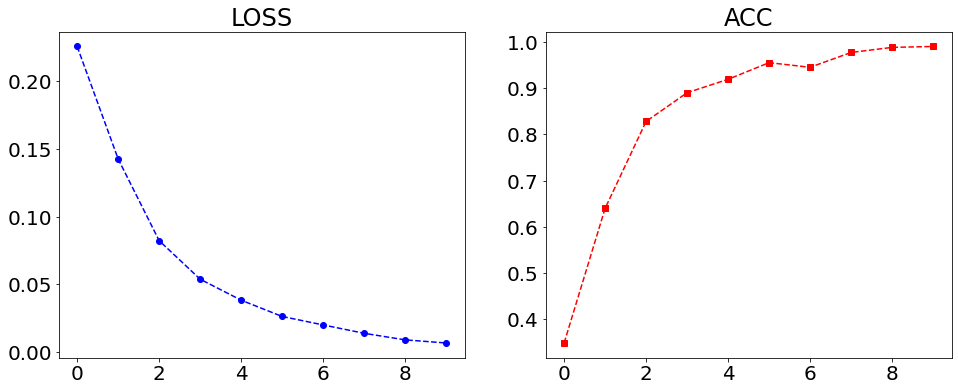

In [43]:
# epochごとの損失関数の可視化
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(cnn1.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(cnn1.log_acc,'rs--');